In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from collections import OrderedDict
import pandas as pd

In [3]:
results_directory  = "/results/GDSC1_PDTC/"
reference = "GDSC1"
tissue = "PDTC"

In [4]:
#specify baseline performance results path here 
datapath = Path(f"{results_directory}/baseline_performances/")

In [5]:
%%time

results = {}
for outer_directory in datapath.glob("*"): 
    drug = outer_directory.stem
    results[drug] = {}
    
    for inner_directory in outer_directory.glob("*"): 
        tissue = inner_directory.stem
        results[drug][tissue] = {}
        if str(inner_directory).split("/")[-1] != ".ipynb_checkpoints":
            data = np.load(inner_directory / "baseline_performance.npz")
            #data = np.load(outer_directory / "baseline_performance.npz")
            for model in ['Linear Regression', 'Nearest Neighbour', 'Random Forest','Neural Network']:
            #for model in ['Linear Regression', 'Nearest Neighbour','Neural Network']:
                zero = data[f"{model}-zero"]
                zero = np.vstack([zero for _ in range(20)]) # There is only 1 possible zero-shot, so expanding for all trials
                performance = np.mean(np.hstack([zero, data[f"{model}-fewshot"]]), axis=0)

                results[drug][tissue][model] = performance    

CPU times: user 94.5 ms, sys: 578 µs, total: 95.1 ms
Wall time: 93.9 ms


In [6]:
#specifiy TCRP performance results path here 
datapath = Path(f"{results_directory}/TCRP_performances/")

In [7]:
%%capture
for i in os.listdir(f"{results_directory}/TCRP_performances/"):
    drug_path = f"{results_directory}/TCRP_performances/{i}/{tissue}"
    for j in os.listdir(drug_path):
        os.system("mv {} {}/TCRP_performance.npz".format(drug_path+'/'+j,drug_path))

mv: '/results/GDSC1_PDTC//TCRP_performances/SL_0101-1/PDTC/TCRP_performance.npz' and '/results/GDSC1_PDTC//TCRP_performances/SL_0101-1/PDTC/TCRP_performance.npz' are the same file
mv: '/results/GDSC1_PDTC//TCRP_performances/PD-173074/PDTC/TCRP_performance.npz' and '/results/GDSC1_PDTC//TCRP_performances/PD-173074/PDTC/TCRP_performance.npz' are the same file
mv: '/results/GDSC1_PDTC//TCRP_performances/AZ628/PDTC/TCRP_performance.npz' and '/results/GDSC1_PDTC//TCRP_performances/AZ628/PDTC/TCRP_performance.npz' are the same file
mv: '/results/GDSC1_PDTC//TCRP_performances/PLX4720/PDTC/TCRP_performance.npz' and '/results/GDSC1_PDTC//TCRP_performances/PLX4720/PDTC/TCRP_performance.npz' are the same file
mv: '/results/GDSC1_PDTC//TCRP_performances/Camptothecin/PDTC/TCRP_performance.npz' and '/results/GDSC1_PDTC//TCRP_performances/Camptothecin/PDTC/TCRP_performance.npz' are the same file
mv: '/results/GDSC1_PDTC//TCRP_performances/PD-0332991/PDTC/TCRP_performance.npz' and '/results/GDSC1_PDTC

In [8]:
%%time

for outer_directory in datapath.glob("*"): 
    drug = outer_directory.stem
    for inner_directory in outer_directory.glob("*"): 
        tissue = inner_directory.stem
        if str(inner_directory).split("/")[-1] != ".ipynb_checkpoints":
            data = np.load(inner_directory / "TCRP_performance.npz")

            for model in ['TCRP']: 
                zero = data[f"{model}-zero"]
                new_data = data["TCRP-fewshot"] 
                fewshot = np.vstack([new_data for _ in range(10)])
                zero = np.vstack([zero for _ in range(10)]) # There is only 1 possible zero-shot, so expanding for all trials
                performance = np.mean(np.hstack([zero, fewshot]), axis=0)
                results[drug][tissue][model] = performance    

CPU times: user 25.3 ms, sys: 3.74 ms, total: 29 ms
Wall time: 28.3 ms


In [9]:
for i in results:
    remove_key = results[i].pop(".ipynb_checkpoints", None)

## Collapsing across all results

In [10]:
results[drug][tissue][model] = performance    

In [11]:
TCRP_results = {'TCRP': []}

for drug, d in results.items(): 
    for tissue, d in d.items(): 
        for model, p in d.items(): 
            if model == "TCRP":
                p = np.nan_to_num(p)
                TCRP_results[model].append(p)

for model, ps in TCRP_results.items(): 
    TCRP_results[model] = np.vstack(ps)

In [12]:
results_by_baseline = {'Linear Regression': [], 'Nearest Neighbour': [], 'Random Forest': [],"TCRP":[],"Neural Network":[]}
#results_by_baseline = {'Linear Regression': [], 'Nearest Neighbour': [],"TCRP":[],"Neural Network":[]}
for drug, d in results.items(): 
    for tissue, d in d.items(): 
        for model, p in d.items(): 
            p = np.nan_to_num(p)
            results_by_baseline[model].append(p)
            
for model, ps in results_by_baseline.items(): 
    results_by_baseline[model] = np.vstack(ps)

In [13]:
import scipy.stats as st
std_list = {"Linear Regression": [],"Nearest Neighbour": [],'Random Forest': [], 'TCRP': [], 'Neural Network': []}
for model, ps in results_by_baseline.items(): 
    min_ci = []
    max_ci = []
    for i in range(ps.shape[1]):
        data = ps[:,i]
        ci = st.t.interval(0.5, len(data)-1, loc=np.mean(data), scale=st.sem(data))
        min_ci.append(ci[0])
        max_ci.append(ci[1])
    std_list[model].extend([np.array(min_ci),np.array(max_ci)])

/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


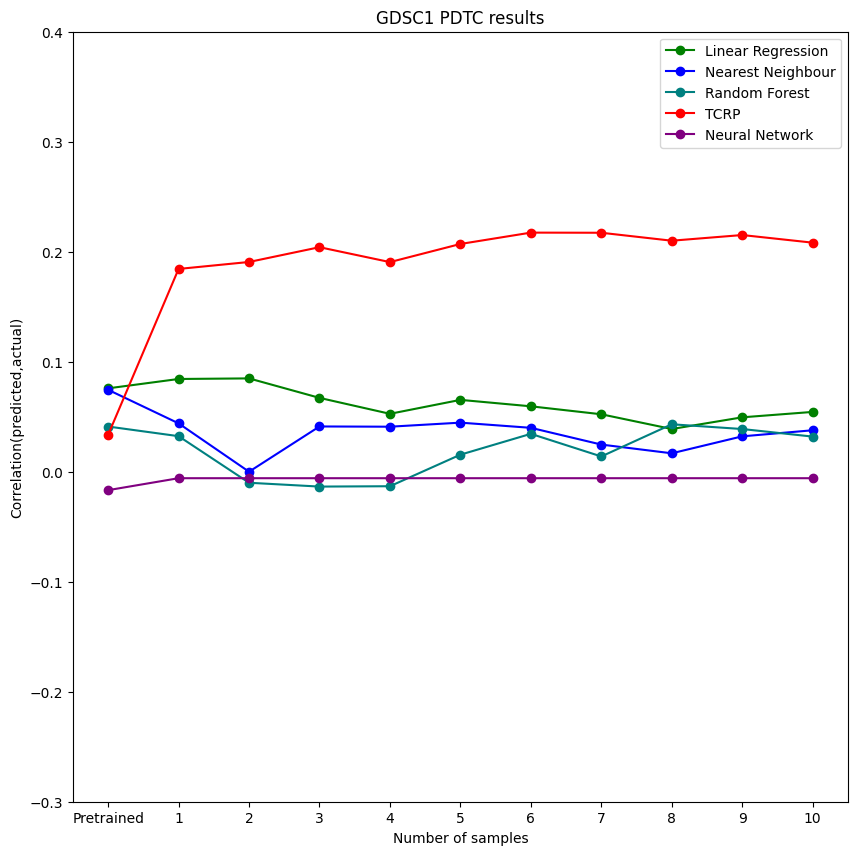

In [14]:
%matplotlib inline
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
color_dict={"Linear Regression":"green","Neural Network":"purple","Random Forest":"teal","Nearest Neighbour": "blue","TCRP":"red"}
for model, ps in results_by_baseline.items(): 
    p = ax.plot(np.arange(11), np.mean(ps, axis=0),label=model,marker='o',color=color_dict[model])
    #ax.vlines(np.arange(11),std_list[model][0],std_list[model][1],color=color_dict[model])
ax.legend()
labels = ['Pretrained'] + [str(i) for i in range(1, 11)]
ax.set_xticks(np.arange(11))
ax.set_xticklabels(labels)
plt.ylim((-0.3,0.4))
plt.ylabel("Correlation(predicted,actual)")
plt.xlabel("Number of samples")
plt.title(f"{reference} {tissue} results")
plt.savefig(f"/results/{reference}_{tissue}.png")

In [15]:
TCRP_drug ={}
linear_drug = {}
RF_drug = {}
KNN_drug = {}
NN_drug = {}
for key,value in results.items():
    print(key)
    if False in np.isnan(results[key]['PDTC']["Nearest Neighbour"]):
        p = np.nan_to_num(results[key]["PDTC"]["Nearest Neighbour"])
    TCRP_drug[key] = np.mean(results[key]["PDTC"]["TCRP"])
    linear_drug[key] = np.mean(results[key]["PDTC"]["Linear Regression"])
    NN_drug[key] = np.mean(results[key]["PDTC"]["Neural Network"])
    RF_drug[key] = np.mean(results[key]["PDTC"]["Random Forest"])
    KNN_drug[key]= np.mean(p)
TCRP_drug = {k: v for k, v in sorted(TCRP_drug.items(), key=lambda item: item[1])}   
linear_drug = dict(OrderedDict((k, linear_drug[k]) for k in list(TCRP_drug.keys())))
NN_drug = dict(OrderedDict((k, NN_drug[k]) for k in list(TCRP_drug.keys())))
RF_drug = dict(OrderedDict((k, RF_drug[k]) for k in list(TCRP_drug.keys())))
KNN_drug = dict(OrderedDict((k, KNN_drug[k]) for k in list(TCRP_drug.keys())))

SL_0101-1
PD-173074
AZ628
PLX4720
Camptothecin
PD-0332991
BX-795
SB_216763
ZM-447439
AZD7762
Bosutinib
JQ1
CHIR-99021
681640
Axitinib
Embelin
CEP-701
KU-55933
RO-3306
GSK-1904529A
BMS-754807
AG-014699
TW_37
MK-2206
JNJ-26854165
BI-2536
GW_441756
Sorafenib
FK866
AMG-706
Gefitinib
GSK269962A


In [16]:
def prepare_points(model_dict):
    items = model_dict.items()
    myList = (items) 
    x, y = zip(*myList) 
    return x,y

In [17]:
TCRP_x,TCRP_y = prepare_points(TCRP_drug)

linear_x,linear_y = prepare_points(linear_drug)
RF_x,RF_y = prepare_points(RF_drug)
KNN_x,KNN_y = prepare_points(KNN_drug)
NN_x,NN_y = prepare_points(NN_drug)

In [18]:
drugs = pd.read_csv("/data/drug_performance.csv")["Drug"].tolist()

In [19]:
new_RF_y = []
new_KNN_y = []
new_NN_y = []
new_linear_y = []
new_TCRP_y = []
for i in drugs:
    if i in RF_x:
        new_RF_y.append(RF_y[RF_x.index(i)])
    else:
        new_RF_y.append(1)
for i in drugs:
    if i in RF_x:
        new_KNN_y.append(KNN_y[KNN_x.index(i)])
    else:
        new_KNN_y.append(1)
for i in drugs:
    if i in RF_x:
        new_linear_y.append(linear_y[linear_x.index(i)])
    else:
        new_linear_y.append(1)
for i in drugs:
    if i in RF_x:
        new_NN_y.append(NN_y[NN_x.index(i)])
    else:
        new_NN_y.append(1)
for i in drugs:
    if i in RF_x:
        new_TCRP_y.append(TCRP_y[TCRP_x.index(i)])
    else:
        new_TCRP_y.append(1)

new_RF_y = tuple(new_RF_y)
new_NN_y = tuple(new_NN_y)
new_KNN_y = tuple(new_KNN_y)
new_linear_y = tuple(new_linear_y)
new_TCRP_y = tuple(new_TCRP_y)

In [20]:
def reverse_tuple(t):
  #condition checking
    if len(t) == 0:
        return t
    else:
        return(t[-1],)+reverse_tuple(t[:-1])

In [21]:
drugs = tuple(drugs)

In [22]:
drugs = reverse_tuple(drugs)

<Figure size 640x480 with 0 Axes>

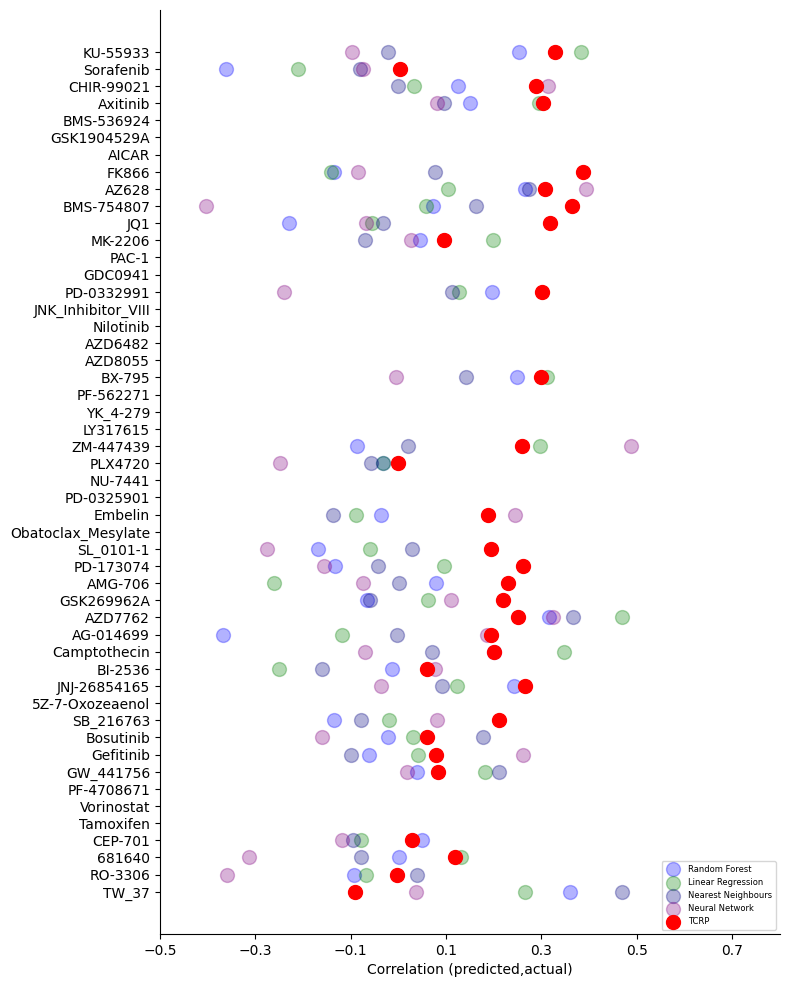

In [24]:
fig = plt.figure()


fig, ax = plt.subplots()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.set_size_inches(8,12)

RF = plt.scatter(reverse_tuple(new_RF_y),drugs,color="blue",s=100, alpha=0.3)
RF.set_label("Random Forest")
linear = plt.scatter(reverse_tuple(new_linear_y),drugs,color="green",s=100, alpha=0.3)
linear.set_label("Linear Regression")
KNN = plt.scatter(reverse_tuple(new_KNN_y),drugs,color="navy",s=100, alpha=0.3)
KNN.set_label("Nearest Neighbours")
NN = plt.scatter(reverse_tuple(new_NN_y),drugs,color="purple",s=100, alpha=0.3)
NN.set_label("Neural Network")
TCRP = plt.scatter(reverse_tuple(new_TCRP_y),drugs,color="red",s=100)
TCRP.set_label("TCRP")
plt.xlabel("Correlation (predicted,actual)")
plt.xlim(-0.5,0.8)
plt.xticks([-0.5,-0.3,-0.1,0.1,0.3,0.5,0.7])
#plt.tight_layout()
plt.legend(loc='lower right',prop={'size': 6})
plt.savefig("/results/original_dotplot.png")

# Find spearman correlation between our values and predicted objective values

In [28]:
from scipy.stats import spearmanr

In [29]:
ground_truth = pd.read_csv("/data/drug_performance.csv")["corr"].tolist()
drugs = pd.read_csv("/data/drug_performance.csv")["Drug"].tolist()

In [30]:
mean_list = []
for i in drugs:
    if i in results.keys():
        mean_list.append(np.mean((results[i][tissue]["TCRP"]).tolist()))
    else:
        mean_list.append(0)

In [31]:
diff_list = []
for i,j in zip(ground_truth,mean_list):
    diff_list.append(abs(i-j))

<Figure size 640x480 with 0 Axes>

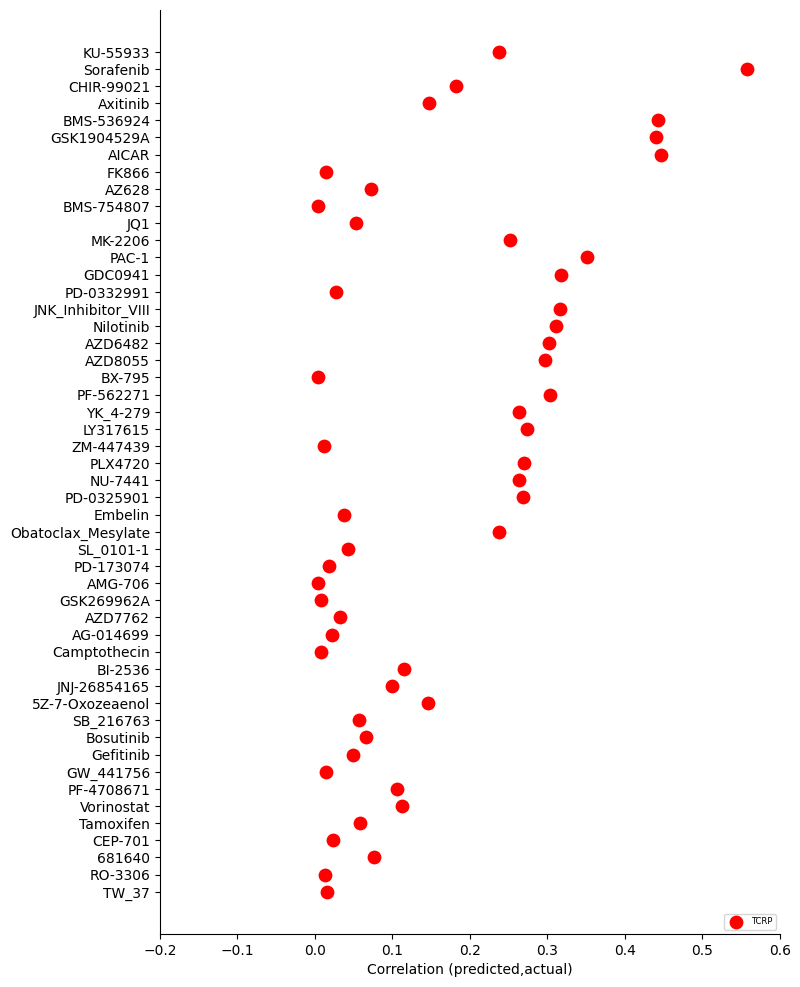

In [34]:
fig = plt.figure()


fig, ax = plt.subplots()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.set_size_inches(8,12)

TCRP = plt.scatter(diff_list,drugs,color="red",s=80)
TCRP.set_label("TCRP")
plt.xlabel("Correlation (predicted,actual)")
plt.xlim(-0.2,0.6)
#plt.xticks([-0.5,-0.3,-0.1,0.1,0.3,0.5,0.7])
#plt.tight_layout()
plt.legend(loc='lower right',prop={'size': 6})
plt.savefig("/results/difference_dotplot.png")